# Finding Lane Lines on the Road

In [1]:
#Import the required libraries
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math

The given image is <class 'numpy.ndarray'> and the dimension is (540, 960, 3)


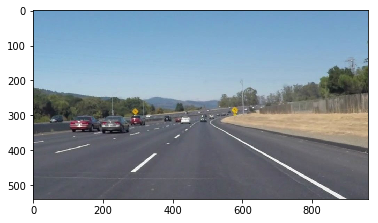

In [2]:
#Displaying the image file
image = mpimg.imread('solidWhiteCurve.jpg')
print('The given image is {} and the dimension is {}'.format(type(image), image.shape))
plt.imshow(image)
plt.show()

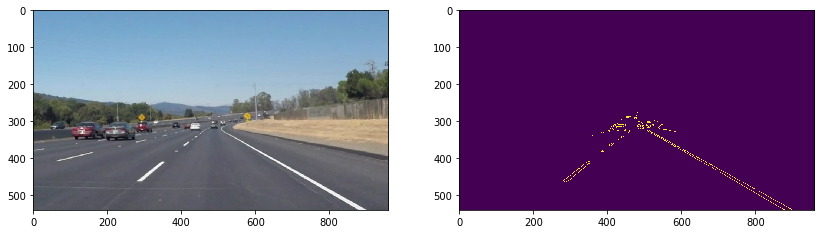

In [3]:
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)

    match_mask_color = 255 # <-- This line altered for grayscale.
    
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

height, width, depth = image.shape
region_of_interest_vertices = [
    (0, height),
    (width / 2, height / 2),
    (width, height),
]

image = mpimg.imread('solidWhiteCurve.jpg')

gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
cannyed_image = cv2.Canny(gray_image, 100, 200)

# Moved the cropping operation to the end of the pipeline.
cropped_image = region_of_interest(
    cannyed_image,
    np.array([region_of_interest_vertices], np.int32))


plt.figure(figsize = (14,12))
plt.subplot(121)
plt.imshow(image)

plt.subplot(122)
plt.imshow(cropped_image)

plt.show()

# Hough Transforms to Detect Lines

In [4]:
lines = cv2.HoughLinesP(cropped_image,
                        rho=4,theta=np.pi / 180,
                        threshold=160,
                        lines=np.array([]),
                        minLineLength=40,maxLineGap=25)

print(lines)

[[[484 309 899 539]]

 [[484 310 812 500]]

 [[483 311 878 539]]

 [[383 382 492 300]]

 [[386 382 490 307]]

 [[281 459 346 410]]]


Each line is represented by four numbers, which are the two endpoints of the detected line segment, like so
(x1, y1, x2, y2).
If we tweak the rho, theta, threshold, minLineLength, and maxLineGap parameters, we can detect many different kinds 
of lines within the image data.

# Rendering Detected Hough Lines as an Overlay

In [5]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    # If there are no lines to draw, exit.
    if lines is None:
            return

    # Make a copy of the original image.
    img = np.copy(img)

    # Create a blank image that matches the original in size.
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    # Loop over all lines and draw them on the blank image.
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)

    # Merge the image with the lines onto the original.
    img = cv2.addWeighted(img, 0.7, line_img, 1.0, 0.0)

    # Return the modified image.
    return img

In [6]:
lines = cv2.HoughLinesP(cropped_image,
                        rho=4,theta=np.pi / 180,
                        threshold=160,
                        minLineLength=50,maxLineGap=25)

In [7]:
image = mpimg.imread('solidWhiteCurve.jpg')
image_with_lines = draw_lines(image, lines)

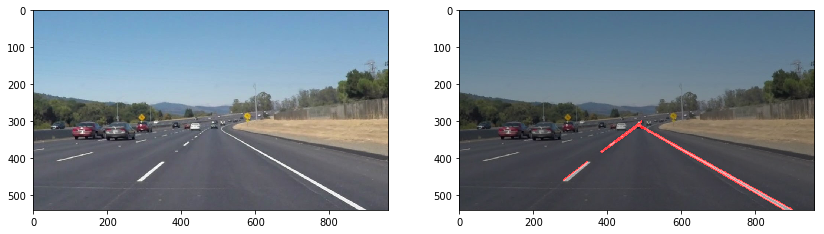

In [8]:
plt.figure(figsize = (14,12))
plt.subplot(121)
plt.imshow(image)

plt.subplot(122)
plt.imshow(image_with_lines)
plt.show()

# Creating a Single Left and Right Lane Line

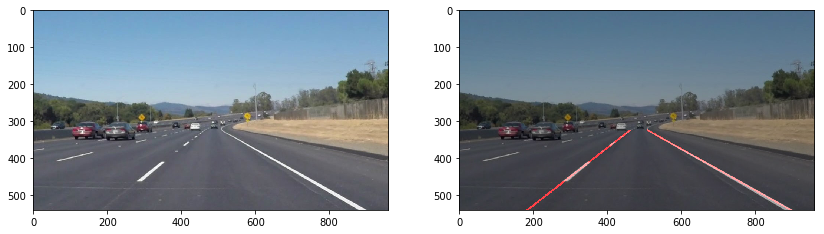

In [9]:
image = mpimg.imread('solidWhiteCurve.jpg')

gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
cannyed_image = cv2.Canny(gray_image, 100, 200)
cropped_image = region_of_interest(
    cannyed_image,
    np.array(
        [region_of_interest_vertices],
        np.int32
    ),
)
lines = cv2.HoughLinesP(
    cropped_image,
    rho=6,
    theta=np.pi / 60,
    threshold=160,
    lines=np.array([]),
    minLineLength=40,
    maxLineGap=25
)

left_line_x = []
left_line_y = []
right_line_x = []
right_line_y = []

for line in lines:
    for x1, y1, x2, y2 in line:
        slope = (y2 - y1) / (x2 - x1) # <-- Calculating the slope.
        if math.fabs(slope) < 0.5: # <-- Only consider extreme slope
            continue
        if slope <= 0: # <-- If the slope is negative, left group.
            left_line_x.extend([x1, x2])
            left_line_y.extend([y1, y2])
        else: # <-- Otherwise, right group.
            right_line_x.extend([x1, x2])
            right_line_y.extend([y1, y2])

min_y = int(image.shape[0] * (3 / 5)) # <-- Just below the horizon
max_y = int(image.shape[0]) # <-- The bottom of the image

poly_left = np.poly1d(np.polyfit(
    left_line_y,
    left_line_x,
    deg=1
))

left_x_start = int(poly_left(max_y))
left_x_end = int(poly_left(min_y))

poly_right = np.poly1d(np.polyfit(
    right_line_y,
    right_line_x,
    deg=1
))

right_x_start = int(poly_right(max_y))
right_x_end = int(poly_right(min_y))

line_image = draw_lines(image,[[[left_x_start, max_y, left_x_end, min_y],[right_x_start, max_y, right_x_end, min_y]]])

plt.figure(figsize = (14,12))
plt.subplot(121)
plt.imshow(image)

plt.subplot(122)
plt.imshow(line_image)

plt.show()

# PIPELINE FOR THE ENTIRE PROGRAM

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    match_mask_color = 255
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    img = np.copy(img)
    if lines is None:
        return

    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)

    img = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)

    return img

def pipeline(image):
    """
    An image processing pipeline which will output
    an image with the lane lines annotated.
    """

    height = image.shape[0]
    width = image.shape[1]
    region_of_interest_vertices = [(0, height),
                                   (width / 2, height / 2),
                                   (width, height)]

    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    cannyed_image = cv2.Canny(gray_image, 100, 200)
 
    cropped_image = region_of_interest(cannyed_image, np.array([region_of_interest_vertices], np.int32))
 
    lines = cv2.HoughLinesP(cropped_image,
                            rho=6,
                            theta=np.pi / 60,
                            threshold=160,
                            lines=np.array([]),
                            minLineLength=40,
                            maxLineGap=25
                           )
 
    left_line_x = []
    left_line_y = []
    right_line_x = []
    right_line_y = []
 
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            if math.fabs(slope) < 0.5:
                continue
            if slope <= 0:
                left_line_x.extend([x1, x2])
                left_line_y.extend([y1, y2])
            else:
                right_line_x.extend([x1, x2])
                right_line_y.extend([y1, y2])

    min_y = int(image.shape[0] * (3 / 5))
    max_y = int(image.shape[0])

    poly_left = np.poly1d(np.polyfit(left_line_y, left_line_x, deg=1))
 
    left_x_start = int(poly_left(max_y))
    left_x_end = int(poly_left(min_y))
 
    poly_right = np.poly1d(np.polyfit(right_line_y, right_line_x, deg=1))
 
    right_x_start = int(poly_right(max_y))
    right_x_end = int(poly_right(min_y))

    line_image = draw_lines(image,
                            [
                                [[left_x_start, max_y, left_x_end, min_y],
                              [right_x_start, max_y, right_x_end, min_y]]
                            ],
                            thickness=5)

    return line_image

In [11]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'solidWhiteRight_output.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(pipeline)
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video solidWhiteRight_output.mp4
[MoviePy] Writing video solidWhiteRight_output.mp4


100%|███████████████████████████████████████▊| 221/222 [00:06<00:00, 33.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: solidWhiteRight_output.mp4 



In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))